In [31]:
import sys
sys.path.append('/workspace/Documents')
# imports
import os, sys
import numpy as np 
import pandas as pd
import nibabel as nb
import ast
import torch
from ema_pytorch import EMA
import torch.nn as nn
import torch.nn.functional as F

import Diffusion_motion_field.Build_lists.Build_list as Build_list
import Diffusion_motion_field.functions_collection as ff
import Diffusion_motion_field.Data_processing as Data_processing
import Diffusion_motion_field.Generator as Generator
import Diffusion_motion_field.denoising_diffusion_pytorch.denoising_diffusion_pytorch.conditional_diffusion_3D as ddpm_3D
import Diffusion_motion_field.denoising_diffusion_pytorch.denoising_diffusion_pytorch.conditional_EDM as edm

main_path = '/mnt/camca_NAS/4DCT'

# turn pred_mvf into voxels unit
class DeNormalizeMVF(nn.Module):
    def __init__(self, image_min=-20.0, image_max=20.0):
        super().__init__()
        self.register_buffer('image_min', torch.tensor(image_min))
        self.register_buffer('image_max', torch.tensor(image_max))

    def forward(self, x_norm):
        # x_norm ∈ [-1, 1]
        scale = (self.image_max - self.image_min) / 2
        shift = (self.image_max + self.image_min) / 2
        return x_norm * scale + shift  # output is voxel-space MVF

In [41]:
data_sheet = os.path.join(main_path,'Patient_lists/uc/patient_list_MVF_diffusion_train_test_filtered_at_least_10tf.xlsx')
# data_sheet = os.path.join(main_path,'Patient_lists/mgh/patient_list_MVF_diffusion_train_test.xlsx')
b = Build_list.Build(data_sheet)
patient_class_list, patient_id_list,_ = b.__build__(batch_list = [5])
patient_class_list = patient_class_list[-20:]
patient_id_list = patient_id_list[-20:]

In [43]:
downsample_list = (True, True, False, False)
model = ddpm_3D.Unet3D_tfcondition(
    init_dim = 64,
    channels = 3 * 10,
    out_dim = 3 * 10,
    conditional_diffusion_image = True,
    conditional_diffusion_EF = True,
    conditional_diffusion_seg = False,
    dim_mults = (1, 2, 4, 8),
    downsample_list = downsample_list,
    upsample_list = (downsample_list[2], downsample_list[1], downsample_list[0], False),
    flash_attn = False, 
    full_attn = (None, None, False ,False), )
diffusion_model = edm.EDM(
    model,
    image_size = [40,40,24],
    num_sample_steps = 100,
    clip_or_not = True,
    clip_range = [-1,1],)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ema = EMA(diffusion_model);ema.to(device)  
data = torch.load('/mnt/camca_NAS/4DCT/models/MVF_EDM_down_10tf_imgcon_EFcon_EFpredict/models/model-1077.pt', map_location=device)
diffusion_model.load_state_dict(data['model']); ema.load_state_dict(data["ema"])

/tmp/ipykernel_10718/488822437.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('/mnt/camca_NAS/4DCT/models/MVF_EDM_down_10tf_imgcon_EFcon_EFpredict/mo

<All keys matched successfully>

In [128]:
i = 0
patient_class = patient_class_list[i]
patient_id = patient_id_list[i]
print(patient_class, patient_id)
   
# get EF
timeframe_info = pd.read_excel('/mnt/camca_NAS/4DCT/Patient_lists/uc/patient_list_final_selection_timeframes.xlsx')
row = timeframe_info[timeframe_info['patient_id'] == patient_id]
preset_EF = round(row['EF_sampled_in_10tf_by_mvf'].iloc[0],2) 
sampled_time_frame_list = ast.literal_eval(row['sampled_time_frame_list'].iloc[0])
normalized_time_frame_list = ast.literal_eval(row['normalized_time_frame_list_copy'].iloc[0])

generator = Generator.Dataset_dual_3D(
                    False,
                    patient_class_list = np.asarray([patient_class]),
                    patient_id_list = np.asarray([patient_id]),
                    mvf_folder = '/workspace/Documents/Data/mvf',
                    how_many_timeframes_together = 10,
                    mvf_size_3D = [40,40,24],
                    latent_size_3D = [40,40,24],
                    slice_range = [0,96],
                    preset_EF = preset_EF,
                    picked_tf = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                    condition_on_image = True,
                    condition_on_seg = False,
                    augment_pre_done = True)

for i in range(0,len(generator)):
    x0_image_data, condition_tf_data, condition_tf_normalized_data, condition_image_data, condition_EF_data,_ = generator[i]

condition_image_data = condition_image_data.unsqueeze(0).to(device)
print(condition_image_data.shape)
condition_EF_data = condition_EF_data.unsqueeze(0).to(device)
ema.ema_model.eval()
pred_mvf = ema.ema_model.sample(condition_image = condition_image_data, condition_EF = condition_EF_data, condition_seg=None, batch_size = 1)

Normal CVC1904240910
torch.Size([1, 1, 40, 40, 24])


sampling time step: 100%|██████████| 100/100 [00:03<00:00, 28.84it/s]


In [129]:
i = 6
patient_class2 = patient_class_list[i]
patient_id2 = patient_id_list[i]
print(patient_class2, patient_id2)
   
# get EF
timeframe_info = pd.read_excel('/mnt/camca_NAS/4DCT/Patient_lists/uc/patient_list_final_selection_timeframes.xlsx')
row2 = timeframe_info[timeframe_info['patient_id'] == patient_id2]
preset_EF2 = round(row2['EF_sampled_in_10tf_by_mvf'].iloc[0],2) 
sampled_time_frame_list2 = ast.literal_eval(row2['sampled_time_frame_list'].iloc[0])
normalized_time_frame_list2 = ast.literal_eval(row2['normalized_time_frame_list_copy'].iloc[0])

generator = Generator.Dataset_dual_3D(
                    False,
                    patient_class_list = np.asarray([patient_class2]),
                    patient_id_list = np.asarray([patient_id2]),
                    mvf_folder = '/workspace/Documents/Data/mvf',
                    how_many_timeframes_together = 10,
                    mvf_size_3D = [40,40,24],
                    latent_size_3D = [40,40,24],
                    slice_range = [0,96],
                    preset_EF = preset_EF2,
                    picked_tf = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                    condition_on_image = True,
                    condition_on_seg = False,
                    augment_pre_done = True)

for i in range(0,len(generator)):
    x0_image_data2, _,_, condition_image_data2, condition_EF_data2,_ = generator[i]

condition_image_data2 = condition_image_data2.unsqueeze(0).to(device)
condition_EF_data2 = condition_EF_data2.unsqueeze(0).to(device)
ema.ema_model.eval()
pred_mvf2 = ema.ema_model.sample(condition_image = condition_image_data2, condition_EF = condition_EF_data2, condition_seg = None,batch_size = 1)
print(pred_mvf2.shape)

Normal CVC2006250902


sampling time step: 100%|██████████| 100/100 [00:03<00:00, 28.80it/s]

torch.Size([1, 30, 40, 40, 24])


In [130]:
condition_image_data_set = torch.cat((condition_image_data, condition_image_data2), dim = 0)

In [131]:
denormalize_mvf = DeNormalizeMVF(image_min=-20.0, image_max=20.0)
pred_mvf_voxel = denormalize_mvf(pred_mvf)
pred_mvf_voxel2 = denormalize_mvf(pred_mvf2)
print('range of pred_mvf after denormalization:', pred_mvf_voxel.min(), pred_mvf_voxel.max())
print('range of pred_mvf2 after denormalization:', pred_mvf_voxel2.min(), pred_mvf_voxel2.max())

pred_mvf_voxel_set = torch.cat((pred_mvf_voxel, pred_mvf_voxel2), dim = 0)
print('pred_mvf_voxel_set shape:', pred_mvf_voxel_set.shape)


range of pred_mvf after denormalization: tensor(-5.1431, device='cuda:0') tensor(4.7622, device='cuda:0')
range of pred_mvf2 after denormalization: tensor(-6.9688, device='cuda:0') tensor(6.9214, device='cuda:0')
pred_mvf_voxel_set shape: torch.Size([2, 30, 40, 40, 24])


In [132]:
# load segmentation
seg_file = os.path.join('/mnt/camca_NAS/4DCT/mvf_aug', patient_class, patient_id, 'aug_0','segmentation', '0.nii.gz')
affine = nb.load(seg_file).affine
seg_img = nb.load(seg_file).get_fdata(); seg_img = np.round(seg_img).astype(np.float32)
seg_img_torch = torch.from_numpy(seg_img).float().unsqueeze(0).unsqueeze(0).to(device)
print(seg_img_torch.shape)

seg_file2 = os.path.join('/mnt/camca_NAS/4DCT/mvf_aug', patient_class2, patient_id2, 'aug_0','segmentation', '0.nii.gz')
seg_img2 = nb.load(seg_file2).get_fdata(); seg_img2 = np.round(seg_img2).astype(np.float32)
seg_img_torch2 = torch.from_numpy(seg_img2).float().unsqueeze(0).unsqueeze(0).to(device)

seg_img_torch_set = torch.cat((seg_img_torch, seg_img_torch2), dim = 0)
print('shape of seg_img_torch_set:', seg_img_torch_set.shape)

torch.Size([1, 1, 40, 40, 24])
shape of seg_img_torch_set: torch.Size([2, 1, 40, 40, 24])


In [133]:
def warp_segmentation_from_mvf(seg_t0, mvf_voxel):
    """
    seg_t0:    [B, 1, X, Y, Z] → will be permuted to [B, 1, Z, Y,X]
    mvf_voxel: [B, 3, X, Y, Z] → will be permuted to [B, 3, Z, Y,X]
    returns:
        warped_seg: [B, 1, X, Y, Z]
    """
    # Step 0: permute to [B, 1, Z, Y,X]
    seg_t0 = seg_t0.permute(0, 1, 4, 3, 2).contiguous()
    mvf_voxel = mvf_voxel.permute(0, 1, 4, 3, 2).contiguous()

    B, _, D, H, W = seg_t0.shape  # Z, Y, X
    device = seg_t0.device

    # Step 1: normalize MVF to [-1, 1]
    mvf_norm = torch.zeros_like(mvf_voxel)
    mvf_norm[:, 0] = mvf_voxel[:, 0] * 2 / (W - 1)  # dx
    mvf_norm[:, 1] = mvf_voxel[:, 1] * 2 / (H - 1)  # dy
    mvf_norm[:, 2] = mvf_voxel[:, 2] * 2 / (D - 1)  # dz

    # Step 2: create identity grid in Z, Y, X order
    grid_z = torch.linspace(-1, 1, D, device=device)
    grid_y = torch.linspace(-1, 1, H, device=device)
    grid_x = torch.linspace(-1, 1, W, device=device)
    meshz, meshy, meshx = torch.meshgrid(grid_z, grid_y, grid_x, indexing='ij')  # [D, H, W]
    identity_grid = torch.stack((meshx, meshy, meshz), dim=-1)  # [D, H, W, 3]
    identity_grid = identity_grid.unsqueeze(0).repeat(B, 1, 1, 1, 1)  # [B, D, H, W, 3]

    # Step 3: add displacement
    displacement_grid = identity_grid + mvf_norm.permute(0, 2, 3, 4, 1)  # [B, D, H, W, 3]

    # Step 4: warp
    warped = F.grid_sample(
        seg_t0, displacement_grid,
        mode='bilinear', padding_mode='border', align_corners=True
    )  # [B, 1, D, H, W]

    # Step 5: permute back to [B, 1, X, Y, Z]
    warped = warped.permute(0, 1, 4,3, 2).contiguous()

    return warped  # [B, 1, X, Y, Z]

In [134]:
pred_mvf_voxel_set_t = pred_mvf_voxel_set[:, 3*4:3*5,...]
# pred_mvf_voxel_set_t = torch.zeros_like(pred_mvf_voxel_set_t).to(device)
# pred_mvf_voxel_set_t[:, 0] = 10.0
seg_t = warp_segmentation_from_mvf(seg_img_torch_set, pred_mvf_voxel_set_t)
# turn into numpy
seg_t = torch.clone(seg_t).detach().cpu().numpy().squeeze() 
seg_t = np.round(seg_t)

# upsample
pred_mvf_voxel_set_t_upsample = F.interpolate(pred_mvf_voxel_set_t, size=(160,160,96), mode='trilinear', align_corners=True)
seg_img_torch_set_upsample = F.interpolate(seg_img_torch_set, size=(160,160,96), mode='trilinear', align_corners=True)
print('shape of pred_mvf_voxel_set_t_upsample:', pred_mvf_voxel_set_t_upsample.shape, ' shape of seg_img_torch_set_upsample:', seg_img_torch_set_upsample.shape)
seg_t_upsample = warp_segmentation_from_mvf(seg_img_torch_set_upsample, pred_mvf_voxel_set_t_upsample)
# turn into numpy
seg_t_upsample = torch.clone(seg_t_upsample).detach().cpu().numpy().squeeze()
seg_t_upsample = np.round(seg_t_upsample)
print('shape of seg_t_upsample:', seg_t_upsample.shape)

print('range of pred_mvf_voxel_set_t:', pred_mvf_voxel_set_t.min(), pred_mvf_voxel_set_t.max())
print('range of pred_mvf_voxel_set_t_upsample:', pred_mvf_voxel_set_t_upsample.min(), pred_mvf_voxel_set_t_upsample.max())
print('range of seg_t_upsample:', seg_t_upsample.min(), seg_t_upsample.max())

shape of pred_mvf_voxel_set_t_upsample: torch.Size([2, 3, 160, 160, 96])  shape of seg_img_torch_set_upsample: torch.Size([2, 1, 160, 160, 96])
shape of seg_t_upsample: (2, 160, 160, 96)
range of pred_mvf_voxel_set_t: tensor(-6.4540, device='cuda:0') tensor(6.9214, device='cuda:0')
range of pred_mvf_voxel_set_t_upsample: tensor(-6.3700, device='cuda:0') tensor(6.8391, device='cuda:0')
range of seg_t_upsample: 0.0 1.0


In [135]:
# use scipy to do the warpping
pred_mvf_voxel_set_t = pred_mvf_voxel_set[:, 3*4:3*5,...]
# pred_mvf_voxel_set_t = torch.zeros_like(pred_mvf_voxel_set_t).to(device)
# pred_mvf_voxel_set_t[:, 0] = 10.0
pred_mvf_voxel_set_t_numpy = torch.clone(pred_mvf_voxel_set_t).detach().cpu().numpy().transpose(0,2,3,4,1)
condition_image_data_numpy = torch.clone(seg_img_torch_set).detach().cpu().numpy().squeeze()
seg_t_approach2 = Data_processing.apply_deformation_field_numpy(np.copy(condition_image_data_numpy[1]), pred_mvf_voxel_set_t_numpy[1],order = 0)

# upsample
pred_mvf_voxel_set_t_numpy_upsample = torch.clone(pred_mvf_voxel_set_t_upsample).detach().cpu().numpy().transpose(0,2,3,4,1)
condition_image_data_numpy_upsample = torch.clone(seg_img_torch_set_upsample).detach().cpu().numpy().squeeze()
print(condition_image_data_numpy_upsample.shape, pred_mvf_voxel_set_t_numpy_upsample.shape)

seg_t_upsample_approach2 = Data_processing.apply_deformation_field_numpy(np.copy(condition_image_data_numpy_upsample[1]), pred_mvf_voxel_set_t_numpy_upsample[1],order = 0)
seg_t_upsample_approach2 = np.round(seg_t_upsample_approach2)


(2, 160, 160, 96) (2, 160, 160, 96, 3)


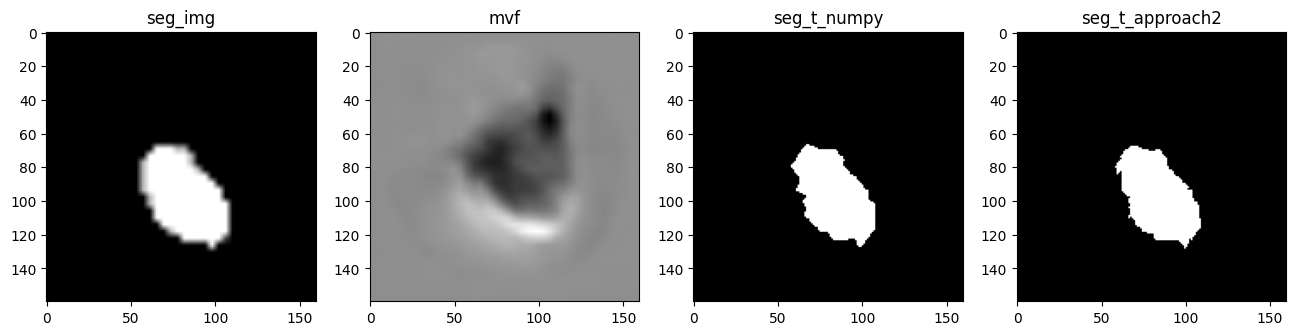

In [136]:
# plot seg_img and seg_t0_numpy side by side
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.title('seg_img')
plt.imshow(condition_image_data_numpy_upsample[1,:,:,36], cmap='gray')
plt.subplot(1, 4, 2)
plt.title('mvf')
plt.imshow(pred_mvf_voxel_set_t_numpy_upsample[1,:,:,36,0], cmap='gray')

plt.subplot(1, 4, 3)
plt.title('seg_t_numpy')
plt.imshow(seg_t_upsample[1,:,:,36] , cmap='gray')
plt.subplot(1, 4, 4)
plt.title('seg_t_approach2')
plt.imshow(seg_t_upsample_approach2[:,:,36], cmap='gray')
plt.show()



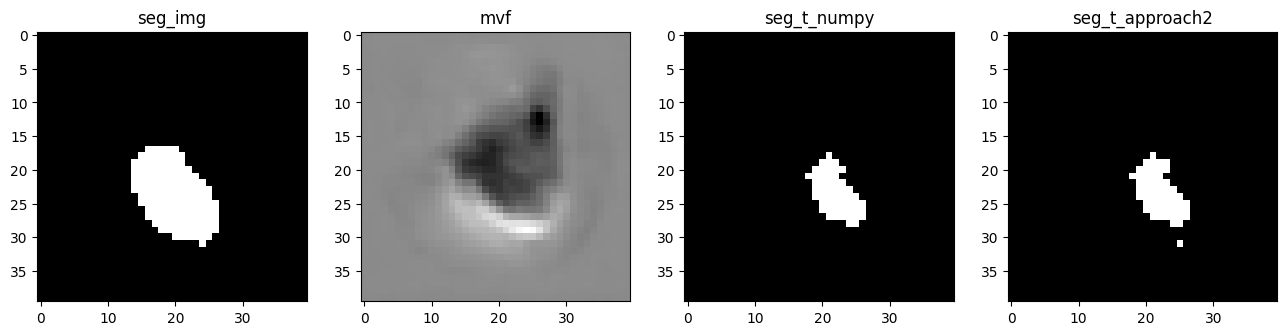

In [137]:
# plot seg_img and seg_t0_numpy side by side
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.title('seg_img')
plt.imshow(condition_image_data_numpy[1,:,:,9], cmap='gray')
plt.subplot(1, 4, 2)
plt.title('mvf')
plt.imshow(pred_mvf_voxel_set_t_numpy[1,:,:,9,0], cmap='gray')

plt.subplot(1, 4, 3)
plt.title('seg_t_numpy')
plt.imshow(seg_t[1,:,:,9], cmap='gray')
plt.subplot(1, 4, 4)
plt.title('seg_t_approach2')
plt.imshow(seg_t_approach2[:,:,9], cmap='gray')
plt.show()


### main function

In [138]:
B,T,X,Y,Z = pred_mvf_voxel_set.shape
seg_img_torch_set_upsample = F.interpolate(seg_img_torch_set, size=(4*X, 4*Y, 4*Z), mode='trilinear', align_corners=True)
volume_list = []
for t in range(10):
    pred_mvf_voxel_set_t = pred_mvf_voxel_set[:, 3*t:3*(t+1),...]
    pred_mvf_voxel_set_t_upsample = F.interpolate(pred_mvf_voxel_set_t, size=(4*X, 4*Y, 4*Z), mode='trilinear', align_corners=True)
    warped_seg_t = warp_segmentation_from_mvf(seg_img_torch_set_upsample, pred_mvf_voxel_set_t_upsample)
    # print('warped_seg_t shape:', warped_seg_t.shape)
    volume_t = warped_seg_t.sum(dim=(1,2,3,4))
    volume_list.append(volume_t)
volumes = torch.stack(volume_list, dim = 1)
print('volumes: ',volumes)
v0 = volumes[:,0]
vmin = volumes.min(dim=1).values
ef_pred = (v0-vmin) / (v0 )
print(ef_pred)

volumes:  tensor([[93243.2656, 92159.2969, 87009.0859, 78191.4219, 73502.1406, 73636.5469,
         81631.2578, 87232.9062, 90053.1562, 90911.6562],
        [77459.2188, 75802.6172, 69173.9141, 61789.8672, 58098.4531, 58060.2891,
         63945.7500, 69177.7969, 72161.7656, 74336.5781]], device='cuda:0')
tensor([0.2117, 0.2504], device='cuda:0')


In [141]:
# use scipy
volume_list_approach2 = []
for t in range(10):
    pred_mvf_voxel_set_t = pred_mvf_voxel_set[:, 3*t:3*(t+1),...]
    pred_mvf_voxel_set_t_upsample = F.interpolate(pred_mvf_voxel_set_t, size=(4*X, 4*Y, 4*Z), mode='trilinear', align_corners=True)
    pred_mvf_voxel_set_t_numpy = torch.clone(pred_mvf_voxel_set_t_upsample).detach().cpu().numpy().transpose(0,2,3,4,1)


    seg_img_torch_set_upsample_numpy = torch.clone(seg_img_torch_set_upsample).detach().cpu().numpy().squeeze()
    warped_seg_t = Data_processing.apply_deformation_field_numpy(seg_img_torch_set_upsample_numpy[0], pred_mvf_voxel_set_t_numpy[0],order = 0)
    warped_seg_t = np.round(warped_seg_t)
    volume_t = np.sum(warped_seg_t == 1)
    volume_list_approach2.append(volume_t)
volume_list_approach2 = np.array(volume_list_approach2)
print('volume_list_approach2:', volume_list_approach2)
ef = (volume_list_approach2[0] - np.min(volume_list_approach2)) / volume_list_approach2[0]
print(ef)

volume_list_approach2: [92305 92125 85807 76494 72091 72150 80433 86333 90539 92035]
0.21899138724879474


In [143]:
# use scipy + zoom
volume_list_approach3 = []
for t in range(10):
    pred_mvf_voxel_set_t = pred_mvf_voxel_set[:, 3*t:3*(t+1),...]
    pred_mvf_voxel_set_t_numpy = torch.clone(pred_mvf_voxel_set_t).detach().cpu().numpy().transpose(0,2,3,4,1)
    pred_mvf_voxel_set_t_numpy = zoom(pred_mvf_voxel_set_t_numpy, (1, 4, 4, 4, 1), order=0)  # zoom to (B, 160, 160, 96, 3)


    seg_img2_upsample = zoom(seg_img, (4, 4, 4), order=0)  # zoom to (160, 160, 96)
    warped_seg_t = Data_processing.apply_deformation_field_numpy(seg_img2_upsample, pred_mvf_voxel_set_t_numpy[0],order = 0)
    warped_seg_t = np.round(warped_seg_t)
    volume_t = np.sum(warped_seg_t == 1)
    volume_list_approach3.append(volume_t)
volume_list_approach3 = np.array(volume_list_approach3)
print('volume_list_approach3:', volume_list_approach3)
ef = (volume_list_approach3[0] - np.min(volume_list_approach3)) / volume_list_approach3[0]
print(ef)

volume_list_approach3: [92641 92269 86045 76679 72402 72452 80525 86588 90428 92153]
0.2184669854600015
